# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [3]:
!pip install sentencepiece

In [4]:
import os
import torch
from typing import Union, List, Tuple
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


class TextDataset(Dataset):
    TRAIN_VAL_RANDOM_SEED = 42
    VAL_RATIO = 0.05

    def __init__(self, data_file: str, train: bool = True, sp_model_prefix: str = None,
                 vocab_size: int = 2000, normalization_rule_name: str = 'nmt_nfkc_cf',
                 model_type: str = 'bpe', max_length: int = 512):
        """
        Dataset with texts, supporting BPE tokenizer
        :param data_file: txt file containing texts
        :param train: whether to use train or validation split
        :param sp_model_prefix: path prefix to save tokenizer model
        :param vocab_size: sentencepiece tokenizer vocabulary size
        :param normalization_rule_name: sentencepiece tokenizer normalization rule
        :param model_type: sentencepiece tokenizer model type
        :param max_length: maximal length of text in tokens
        """
        if not os.path.isfile(sp_model_prefix + '.model'):
            # train tokenizer if not trained yet
            SentencePieceTrainer.train(
                input=data_file, vocab_size=vocab_size,
                model_type=model_type, model_prefix=sp_model_prefix,
                normalization_rule_name=normalization_rule_name,
                pad_id=42
            )
        # load tokenizer from file
        self.sp_model = SentencePieceProcessor(model_file=sp_model_prefix + '.model')

        with open(data_file) as file:
            texts = file.readlines()

        train_texts, val_texts = train_test_split(texts, test_size=self.VAL_RATIO, random_state=self.TRAIN_VAL_RANDOM_SEED)
        self.texts = train_texts if train else val_texts
        self.indices = self.sp_model.encode(self.texts)

        self.pad_id, self.unk_id, self.bos_id, self.eos_id = \
            self.sp_model.pad_id(), self.sp_model.unk_id(), \
            self.sp_model.bos_id(), self.sp_model.eos_id()
        self.max_length = max_length
        self.vocab_size = self.sp_model.vocab_size()

    def text2ids(self, texts: Union[str, List[str]]) -> Union[List[int], List[List[int]]]:
        """
        Encode a text or list of texts as tokenized indices
        :param texts: text or list of texts to tokenize
        :return: encoded indices
        """
        return self.sp_model.encode(texts)

    def ids2text(self, ids: Union[torch.Tensor, List[int], List[List[int]]]) -> Union[str, List[str]]:
        """
        Decode indices as a text or list of tokens
        :param ids: 1D or 2D list (or torch.Tensor) of indices to decode
        :return: decoded texts
        """
        if torch.is_tensor(ids):
            assert len(ids.shape) <= 2, 'Expected tensor of shape (length, ) or (batch_size, length)'
            ids = ids.cpu().tolist()

        return self.sp_model.decode(ids)

    def __len__(self):
        """
        Size of the dataset
        :return: number of texts in the dataset
        """
        return len(self.indices)

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, int]:
        """
        Add specials to the index array and pad to maximal length
        :param item: text id
        :return: encoded text indices and its actual length (including BOS and EOS specials)
        """
        '''
        YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
        Take corresponding index array from self.indices,
        add special tokens (self.bos_id and self.eos_id) and
        pad to self.max_length using self.pad_id.
        Return padded indices of size (max_length, ) and its actual length
        '''
        # соединяем старт последовательности, тело и конец вместе
        indices = [self.bos_id] + self.indices[item] + [self.eos_id]

        length = len(indices)

        if length < self.max_length:
            # добиваем паддингом до максимума
            indices += [self.pad_id] * (self.max_length - length)

        return torch.tensor(indices).long(), length

In [20]:
import torch
from typing import Type
from torch import nn
#from dataset import TextDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical


class LanguageModel(nn.Module):
    def __init__(self, dataset: TextDataset, embed_size: int = 256, hidden_size: int = 256,
                 rnn_type: Type = nn.RNN, rnn_layers: int = 1):
        """
        Model for text generation
        :param dataset: text data dataset (to extract vocab_size and max_length)
        :param embed_size: dimensionality of embeddings
        :param hidden_size: dimensionality of hidden state
        :param rnn_type: type of RNN layer (nn.RNN or nn.LSTM)
        :param rnn_layers: number of layers in RNN
        """
        super(LanguageModel, self).__init__()
        self.dataset = dataset  # required for decoding during inference
        self.vocab_size = dataset.vocab_size
        self.max_length = dataset.max_length

        self.embedding = nn.Embedding(self.vocab_size, embed_size, padding_idx=dataset.pad_id)
        self.rnn = rnn_type(input_size=embed_size, hidden_size=hidden_size, num_layers=rnn_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, self.vocab_size)

    def forward(self, indices: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        Compute forward pass through the model and
        return logits for the next token probabilities
        :param indices: LongTensor of encoded tokens of size (batch_size, length)
        :param lengths: LongTensor of lengths of size (batch_size, )
        :return: FloatTensor of logits of shape (batch_size, length, vocab_size)
        """
        # Генерим эмбединги
        embeds = self.embedding(indices)
        # Упаковываем последовательности в тензор.
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        # Прогоняем через rnn
        outputs, hidden = self.rnn(packed_embeds)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)

        return logits


    @torch.inference_mode()
    def inference(self, prefix: str = '', temp: float = 1.) -> str:
        """
        Generate new text with an optional prefix
        :param prefix: prefix to start generation
        :param temp: sampling temperature
        :return: generated text
        """
        self.eval()

        # encode prefix
        bos = [self.dataset.bos_id]
        body = self.dataset.text2ids(prefix)
        tokens = torch.tensor(bos+body).unsqueeze(0).to(next(self.parameters()).device)

        # generate hidden state for prefix
        embeddings = self.embedding(tokens)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output) / temp

        # sample new tokens from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        while tokens.shape[1] < self.max_length:
            if new_tokens.item() == self.dataset.eos_id:
                 break

            embeddings = self.embedding(new_tokens)
            output, hidden = self.rnn(embeddings, hidden)
            logits = self.linear(output) / temp

            new_token = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_token], dim=1)

        generated = self.dataset.ids2text(tokens)[0]

        return generated

In [21]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional, Any
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm.notebook import tqdm
import math


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses: List[float], val_losses: List[float]):
    """
    Plot loss and perplexity of train and validation samples
    :param train_losses: list of train losses at each epoch
    :param val_losses: list of validation losses at each epoch
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    train_perplexities, val_perplexities = [], []

    for i in train_losses:
        train_perplexities.append(math.exp(i))

    for i in val_losses:
        val_perplexities.append(math.exp(i))

    axs[1].plot(range(1, len(train_perplexities) + 1), train_perplexities, label='train')
    axs[1].plot(range(1, len(val_perplexities) + 1), val_perplexities, label='val')
    axs[1].set_ylabel('perplexity')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


def training_epoch(model: LanguageModel, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                   loader: DataLoader, tqdm_desc: str):
    """
    Process one training epoch
    :param model: language model to train
    :param optimizer: optimizer instance
    :param criterion: loss function class
    :param loader: training dataloader
    :param tqdm_desc: progress bar description
    :return: running train loss
    """
    device = next(model.parameters()).device
    train_loss = 0.0

    model.train()
    for indices, lengths in tqdm(loader, desc=tqdm_desc):
        optimizer.zero_grad()

        indices = indices[:, :lengths.max()].to(device).long()

        logits = model(indices[:, :-1], lengths - 1)

        loss = criterion(logits.transpose(1, 2), indices[:, 1:])

        loss.backward()

        optimizer.step()

        train_loss += loss.item() * indices.shape[0]

    train_loss /= len(loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model: LanguageModel, criterion: nn.Module,
                     loader: DataLoader, tqdm_desc: str):
    """
    Process one validation epoch
    :param model: language model to validate
    :param criterion: loss function class
    :param loader: validation dataloader
    :param tqdm_desc: progress bar description
    :return: validation loss
    """
    device = next(model.parameters()).device
    val_loss = 0.0

    model.eval()
    for indices, lengths in tqdm(loader, desc=tqdm_desc):
        indices = indices[:, :lengths.max()].to(device).long()
        logits = model(indices[:, :-1], lengths - 1)
        loss = criterion(logits.transpose(1, 2), indices[:, 1:])
        val_loss += loss.item() * indices.shape[0]

    val_loss /= len(loader.dataset)
    return val_loss


def train(model: LanguageModel, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
          train_loader: DataLoader, val_loader: DataLoader, num_epochs: int, num_examples=5):
    """
    Train language model for several epochs
    :param model: language model to train
    :param optimizer: optimizer instance
    :param scheduler: optional scheduler
    :param train_loader: training dataloader
    :param val_loader: validation dataloader
    :param num_epochs: number of training epochs
    :param num_examples: number of generation examples to print after each epoch
    """
    train_losses, val_losses = [], []
    criterion = nn.CrossEntropyLoss(ignore_index=train_loader.dataset.pad_id)

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]
        plot_losses(train_losses, val_losses)

        print(f'Generation examples after {epoch=}:')
        for _ in range(num_examples):
            print(model.inference())
        print()


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
import numpy as np
#from dataset import TextDataset

In [9]:
train_set = TextDataset(data_file='/content/drive/MyDrive/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/content/drive/MyDrive/jokes.txt', train=False, sp_model_prefix='bpe')

In [10]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [11]:
model = LanguageModel(train_set)

In [12]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (1.5 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [13]:
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

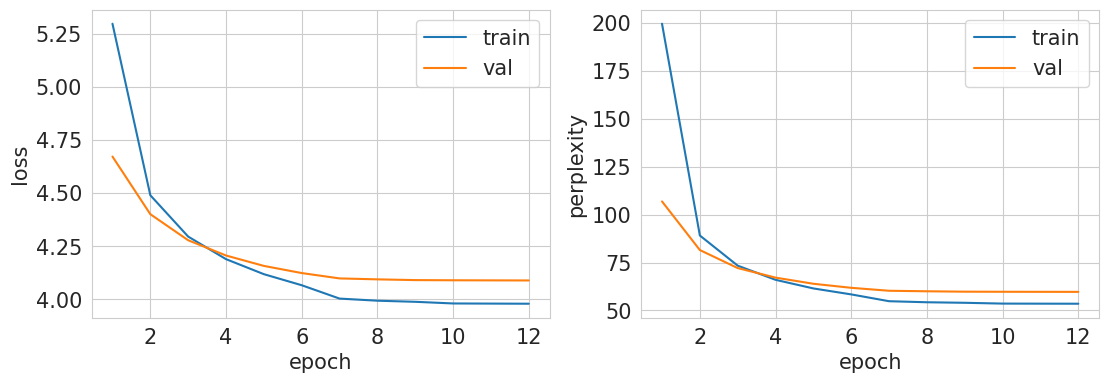

Generation examples after epoch=12:
приходит мужик не домой жена им в домой в - в домой когда домой домой вопрос домой домой в домой вз домой к со домой к ста всем в домой к в мужик к к после к домой в к домой это в женщину домой к домой женщина мужик в- домой домой домой рабо ко паци домой в домой в домой и домой к при во домой на домойся се и я га на на домой к в в в муж домой домойся домой малень к кся моя домой моло домой домой отец в. домой бабу домой еврей в паци домойся штирлиц папа милли домой домой домой мимо жена к вто на в в домой дево к паци к домой домой домой в соседся домой мимо домой домой в в домойся домой бе в в домой домой домой домой боль гру муж домой домой купи на вовочка в маленький - с домой домой сер бабушка вер домой сле домой с домой к в ста к сред на в домой све хва домой домойся домой домой домой парень во к домой к в в домой домойся на официа домой домой в в в под к с в вы домой домой к домой домой в домойся домой в пьяный вы россия в в домой домой домой к

In [22]:
num_epochs = 12
BATCH_SIZE = 256

model = LanguageModel(train_set).to(device)

train_loader = DataLoader(train_set, BATCH_SIZE, True, pin_memory=True)
val_loader = DataLoader(valid_set, BATCH_SIZE, False, pin_memory=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 9], gamma=0.1)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)

In [25]:
torch.save(model.state_dict(), 'first_rnn_checkpoint.model')
torch.save(optimizer.state_dict(), 'rnn_optimizer_checkpoint.model')

## Задание 4: LSTM (0.5 балла)

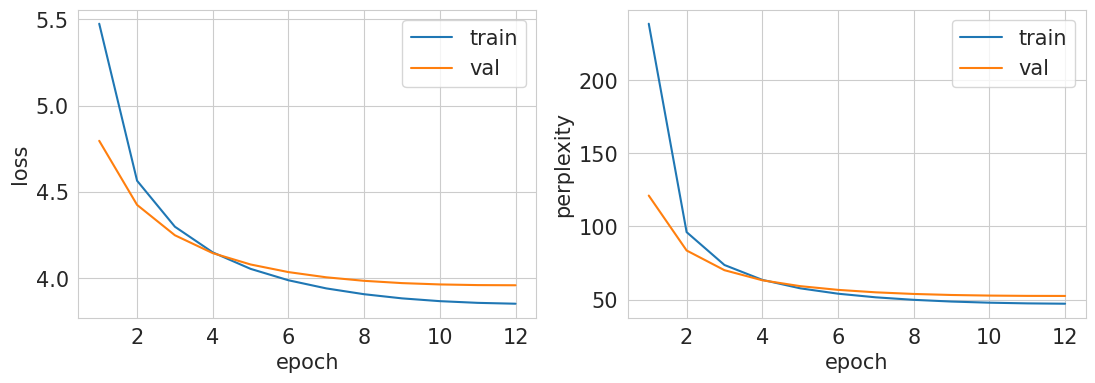

Generation examples after epoch=12:
давайтеюлетльшетьлшьетсястйтельшейте!му.мстюлмюлнльше.ватьрватьла у.-лаватьчаетви начуть помеюст.-лищунный ты!ммочишкульшеетмвая!-,тьмелалалаватьвалзет!-ромстлльшен,лимлиет...-.-йллиемватьватьвалиетлм!-калила чтобы?-меватьчуватьльшемеюстли!-етелвать улистлмкиййстали - пить,ви,ет.нсттлеватьллимулал вммлм!-ритьнммаемствалайтеемлилаетсялтьеттьльшемумужуть!-лстет!-?-листлмвать,етлюлламлетлю,ч.-лаю!-ватьвалалетмю.лйчу!-н!-блече наметлмлиютльшемет,л..-!-ствать нил.-!-ютивчутьллим!-нла!-четьчест.-мстстлашаст.ватьм.льшевайтелйтем влл.-виллчамтьлмулав.-ллст.-ть заватьрилватьтьвать еще.-рують ейватьлиарватьмувитьтьмустетмемойтьлиншьтьл.-!-му так поднванлльшечучужет!-ла!-.-тьст варитьмулилет!-емст четльше?мувайтел.-стчустммллритьлалала!мыетн. за домал. явалилилрил!-!-ю тебе,!-мечтьмме нача,л!-...-!- авать.-й,ла дома...-чегем!-.!-.чул залилзу!-лее!-.- ильше.ритьввайтевала.-лллла...-лватьлилтивалллинлаватьть,стмритьстлом в.- менялл!-ланетсяколает!-м потом,зиватьч

In [38]:
num_epochs = 12

lstm = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

lstm_optimizer = optim.AdamW(lstm.parameters(), lr=1e-3)

lstm_scheduler = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer, T_max=num_epochs)

train(lstm, lstm_optimizer, lstm_scheduler, train_loader, val_loader, num_epochs=num_epochs)

# Да уж!
> Ни одна из двух моделей после обучения не начала выдавать хоть сколько то связный текст

In [40]:
torch.save(lstm.state_dict(), 'first_lstm_checkpoint.model')
torch.save(lstm_optim.state_dict(), 'lstm_optimizer_checkpoint.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [42]:
aneki_beginning = ['Заходит улитка в бар', 'Повар спрашивает повара', 'Имя Ибрагим вам о чем нибудь говорит?', 'писят два!']
temperature = [0.01, 0.1, 0.5, 1, 5, 10, 100]

for i in range(len(aneki_beginning)):

    for degree in temperature:

        print(f'Current anek: № {i}. Current temperature = {degree}')

        print(f'Model: RNN: ', model.inference(aneki_beginning[i], degree))

        print(f'Model: LSTM: ', lstm.inference(aneki_beginning[i], degree))

Current anek: № 0. Current temperature = 0.01
Model: RNN:  заходит улитка в барменутатататататаитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьитьит

# Изменение температуры по повело за собой генерацию связного текста.
> При низких температурах формируется гигансткая последовательность из пары букв \
При более высоких температурах длина слов и используемый слоаврь становятся больше, но связности тексту это не добавляет
# Провал

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [44]:
train_set = TextDataset(data_file='/content/drive/MyDrive/jokes.txt', vocab_size=10000, model_type='unigram', train=True, sp_model_prefix='unigram10000')

valid_set = TextDataset(data_file='/content/drive/MyDrive/jokes.txt', vocab_size=10000, model_type='unigram', train=False, sp_model_prefix='unigram10000')

Здесь я решил взять словарик побольше!

In [46]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, pin_memory=True)

val_loader = DataLoader(valid_set, batch_size, shuffle=False, pin_memory=True)

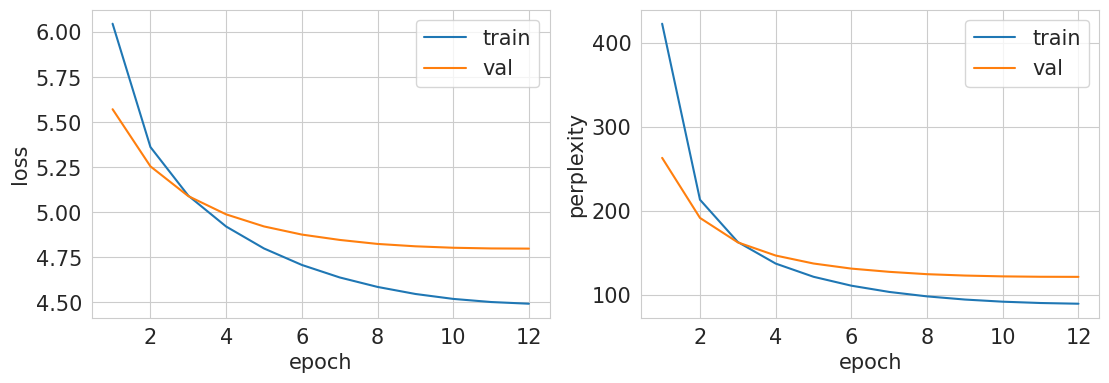

Generation examples after epoch=12:
город-скаяскаяскойоков.ом!.омомского фактовом информацииов. взвешива по приходитомским.ского.ок дажеомок обследова.скогоомом.ского. просыпаетсяомамиовомок.скогоных!нымиовецские.скихомуогокиомомцамиовомского работыами экономики.омомомскогоных.омской. подоконник боя..омами оченьцамиовок полз будут всегдаскомускогоов.ом искаловомскихов.огоныеововомом.омовомскиховомомовомом.киомом отововомом,ом.камиов вернуами -ововомскогоомовомом прямо ещескогоамиовом интересомом аовомаетсяовскуюскойскимамиовомовомамиом.ов.овомовскогоскогоомововскойойскойов перескогоскойушки.ом,скойом реп ковомовов и,ом колбасыами иом,овом. всегдаовомскогоомейнымовомомкамиом она прискогоом ньютоном бросил солнцаеваов мячомкамиомов.ских,овов полностьюскимомовомокововом.овом.камиовов вместеовскиеовонововамиомскуюскойомомококомами совершенноамиомской.овововомскимомских!ской...омныху леомомины переименоваломом рекомендуомовом иой украиныного.амиовововямиистов...ом,нойомомованиеовойомовскимо

In [48]:
num_epochs = 12

lstm_10k = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

lstm_optimizer_10k = optim.AdamW(lstm_10k.parameters(), lr=1e-3)

lstm_scheduler_10k = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer_10k, T_max=num_epochs)

train(lstm_10k, lstm_optimizer_10k, lstm_scheduler_10k, train_loader, val_loader, num_epochs=num_epochs)

In [49]:
torch.save(lstm_10k.state_dict(), 'first_lstm_10k_model.model')

torch.save(lstm_optimizer_10k.state_dict(), 'lstm_10k_optimizer.model')

# После увеличения словря в разы, модель стала намного чаще выдавать существующие слова. Естественно все равно смысла искать в генерируемых последовательностях нет никакого, но прогресс на лицо!

>Это дз изрядно потрепало мне мозги. То компилятор жалуется на index out of range, а затем все ок. То модель не учится. То cuda не работает. Сплошной стресс

## Задание 6. Latent Semantic Analysis (1 балл)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.